# ism Import and Plotting

This example shows how to measure an impedance spectrum and then plot it in Bode and Nyquist using the Python library [matplotlib](https://matplotlib.org/).

In [1]:
import sys
from thales_remote.connection import ThalesRemoteConnection
from thales_remote.script_wrapper import PotentiostatMode,ThalesRemoteScriptWrapper

from thales_file_import.ism_import import IsmImport
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import EngFormatter


# Connect Python to the already launched Thales-Software

In [26]:
if __name__ == "__main__":
    zenniumConnection = ThalesRemoteConnection()
    connectionSuccessful = zenniumConnection.connectToTerm("localhost", "ScriptRemote")
    if connectionSuccessful:
        print("connection successfull")
    else:
        print("connection not possible")
        sys.exit()
          
    zahnerZennium = ThalesRemoteScriptWrapper(zenniumConnection)
    zahnerZennium.forceThalesIntoRemoteScript()
    
    zahnerZennium.calibrateOffsets()

connection successfull


# Setting the parameters for the measurement

After the connection with Thales, the naming of the files of the measurement results is set.

Measure EIS spectra with a sequential number in the file name that has been specified.
Starting with number 1.

In [ ]:
    zahnerZennium.setEISNaming("counter")
    zahnerZennium.setEISCounter(1)
    zahnerZennium.setEISOutputPath(r"C:\THALES\temp\test1")
    zahnerZennium.setEISOutputFileName("spectra")

Setting the parameters for the spectra.
Alternatively a rule file can be used as a template.

In [ ]:
    zahnerZennium.setPotentiostatMode(PotentiostatMode.POTMODE_POTENTIOSTATIC)
    zahnerZennium.setAmplitude(10e-3)
    zahnerZennium.setPotential(0)
    zahnerZennium.setLowerFrequencyLimit(0.01)
    zahnerZennium.setStartFrequency(1000)
    zahnerZennium.setUpperFrequencyLimit(200000)
    zahnerZennium.setLowerNumberOfPeriods(3)
    zahnerZennium.setLowerStepsPerDecade(5)
    zahnerZennium.setUpperNumberOfPeriods(20)
    zahnerZennium.setUpperStepsPerDecade(10)
    zahnerZennium.setScanDirection("startToMax")
    zahnerZennium.setScanStrategy("single")

After setting the parameters, the measurement is started.  

<div class="alert alert-block alert-info">
<b>Note:</b> If the potentiostat is set to potentiostatic before the impedance measurement and is switched off, the measurement is performed at the open circuit voltage/potential.
</div>

After the measurement, the potentiostat is switched off and the amplitude is deactivated.

In [29]:
    zahnerZennium.enablePotentiostat()
    zahnerZennium.measureEIS()
    zahnerZennium.disablePotentiostat()
    
    zahnerZennium.setAmplitude(0)
    
    zenniumConnection.disconnectFromTerm()

# Importing the ism file

Import the spectrum from the previous measurement with the class [IsmImport](https://doc.zahner.de/thales_remote/thales_file_import.html#impedance-spectra-ism). This was saved under the set path and name with the number expanded.  
The measurement starts at 1 therefore the following path results: "C:\THALES\temp\test1\spectra_0001.ism".

In [30]:
    ismFile = IsmImport(r"C:\THALES\temp\test1\spectra_0001.ism")
    
    impedanceFrequencies = ismFile.getFrequencyArray()
    
    impedanceAbsolute = ismFile.getImpedanceArray()
    impedancePhase = ismFile.getPhaseArray()
    
    impedanceComplex = ismFile.getComplexImpedanceArray()

The Python datetime object of the measurement date is output to the console next.

In [31]:
    print("Measurement end time: " + str(ismFile.getMeasurementEndDateTime()))

Measurement end time: 2021-10-14 13:21:30.032500


# Displaying the measurement results

The spectra are presented in the Bode and Nyquist representation. For this test, the Zahner test box was measured in the lin position.

## Nyquist Plot

The matplotlib diagram is configured to match the Nyquist representation. For this, the diagram aspect is set equal and the axes are labeled in engineering units. The axis labeling is realized with [LaTeX](https://www.latex-project.org/) for subscript text.

The possible settings of the graph can be found in the detailed documentation and tutorials of [matplotlib](https://matplotlib.org/).

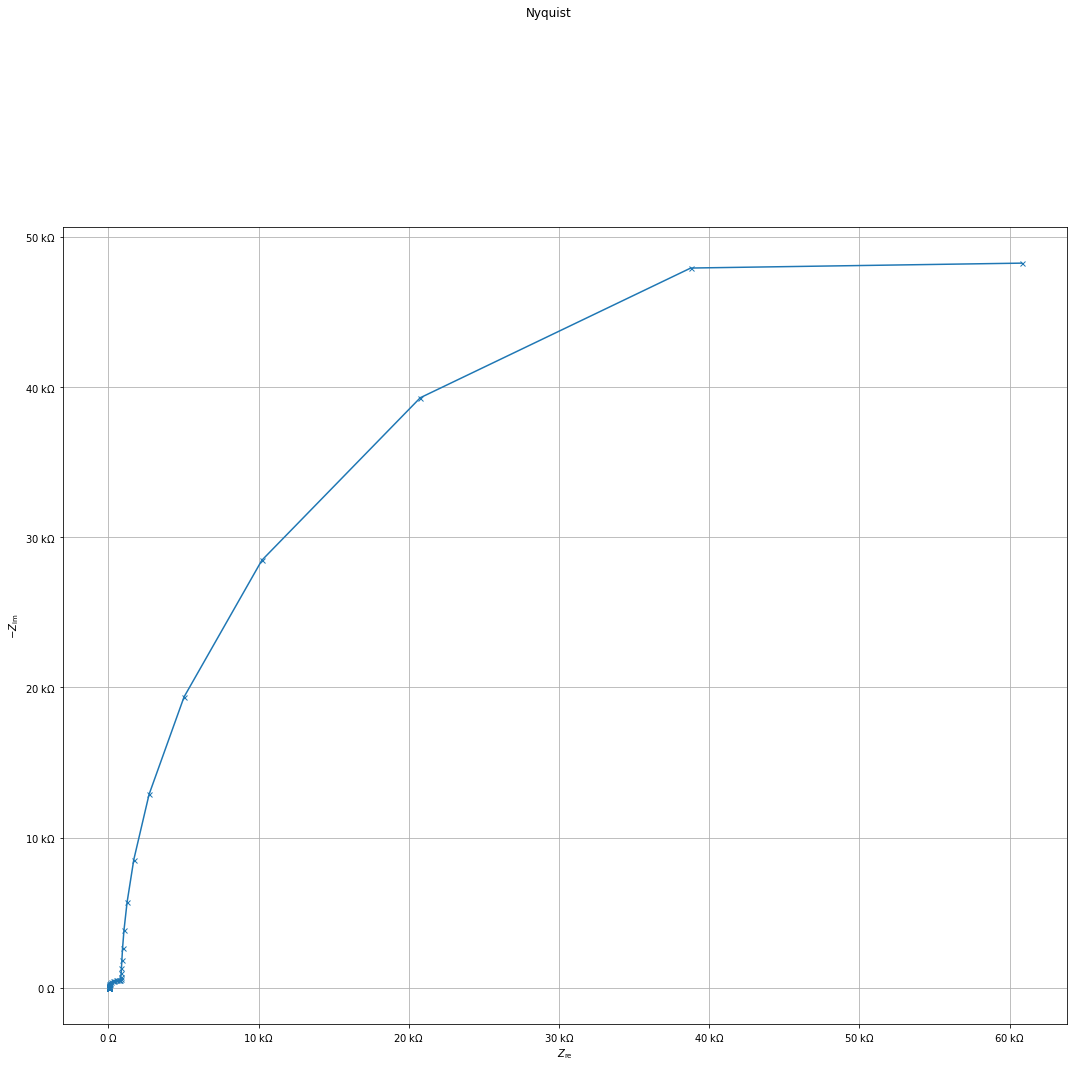

In [49]:
    figNyquist, (nyquistAxis) = plt.subplots(1, 1)
    figNyquist.suptitle("Nyquist")
    
    nyquistAxis.plot(np.real(impedanceComplex), -np.imag(impedanceComplex), marker="x", markersize=5)
    nyquistAxis.grid(which="both")
    nyquistAxis.set_aspect("equal")
    nyquistAxis.xaxis.set_major_formatter(EngFormatter(unit="$\Omega$"))
    nyquistAxis.yaxis.set_major_formatter(EngFormatter(unit="$\Omega$"))
    nyquistAxis.set_xlabel(r"$Z_{\rm re}$")
    nyquistAxis.set_ylabel(r"$-Z_{\rm im}$")
    figNyquist.set_size_inches(18, 18)
    plt.show()
    figNyquist.savefig("nyquist.svg")

## Bode Plot

The matplotlib representation was also adapted for the Bode plot. A figure with two plots was created for the separate display of phase and impedance which are plotted over the same x-axis.

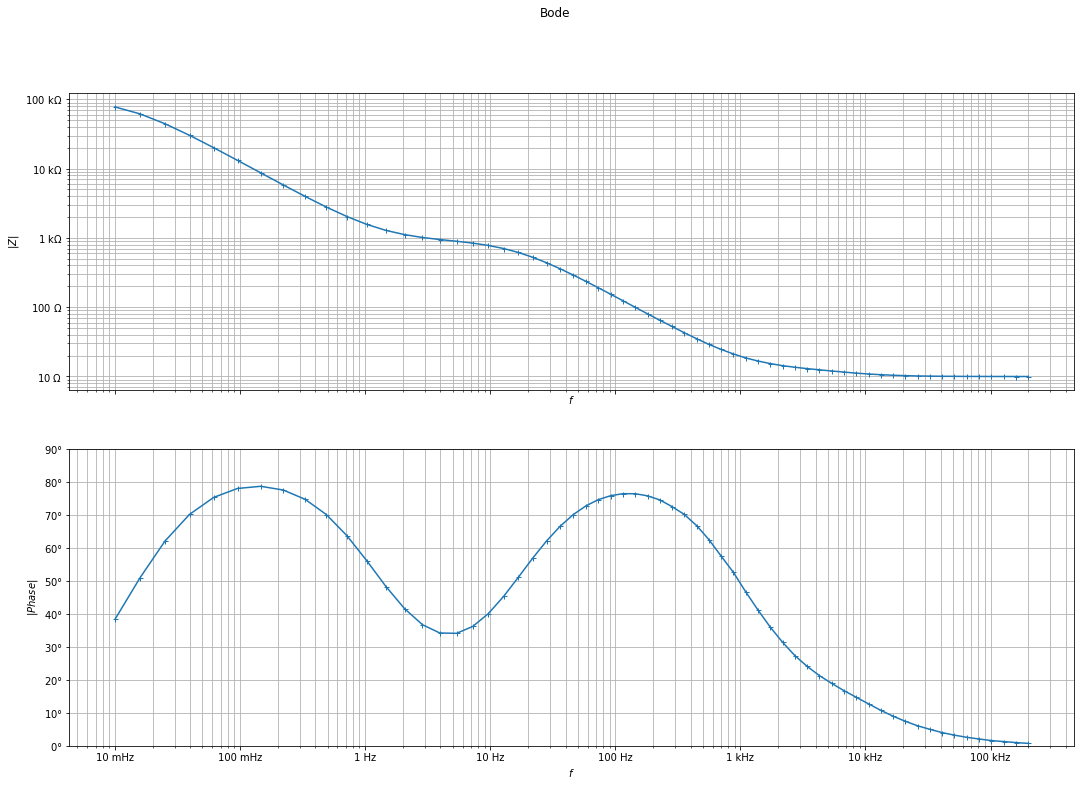

In [48]:
    figBode, (impedanceAxis, phaseAxis) = plt.subplots(2, 1, sharex=True)
    figBode.suptitle("Bode")
    
    impedanceAxis.loglog(impedanceFrequencies, impedanceAbsolute, marker="+", markersize=5)
    impedanceAxis.xaxis.set_major_formatter(EngFormatter(unit="Hz"))
    impedanceAxis.yaxis.set_major_formatter(EngFormatter(unit="$\Omega$"))
    impedanceAxis.set_xlabel(r"$f$")
    impedanceAxis.set_ylabel(r"$|Z|$")
    impedanceAxis.grid(which="both")
    
    phaseAxis.semilogx(impedanceFrequencies, np.abs(impedancePhase * (360 / (2 * np.pi))), marker="+", markersize=5)
    phaseAxis.xaxis.set_major_formatter(EngFormatter(unit="Hz"))
    phaseAxis.yaxis.set_major_formatter(EngFormatter(unit="$°$", sep=""))
    phaseAxis.set_xlabel(r"$f$")
    phaseAxis.set_ylabel(r"$|Phase|$")
    phaseAxis.grid(which="both")
    phaseAxis.set_ylim([0, 90])
    figBode.set_size_inches(18, 12)
    plt.show()
    figBode.savefig("bode.svg")